D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn

Selected Day for Simulation: 2022-08-25
Finding optimal temporal disaggregation for regular hours...
k=1: Avg dispatch interval = 11.78 minutes
k=2: Avg dispatch interval = 12.27 minutes
k=3: Avg dispatch interval = 12.80 minutes
k=4: Avg dispatch interval = 12.14 minutes
k=5: Avg dispatch interval = 12.27 minutes
k=6: Avg dispatch interval = 12.21 minutes
k=7: Avg dispatch interval = 12.09 minutes
k=8: Avg dispatch interval = 12.04 minutes
k=9: Avg dispatch interval = 11.70 minutes
k=10: Avg dispatch interval = 12.42 minutes
k=11: Avg dispatch interval = 12.85 minutes
k=12: Avg dispatch interval = 14.29 minutes
k=13: Avg dispatch interval = 14.35 minutes
k=14: Avg dispatch interval = 15.31 minutes
k=15: Avg dispatch interval = 16.55 minutes
k=16: Avg dispatch interval = 15.16 minutes
k=17: Avg dispatch interval = 15.15 minutes
k=18: Avg dispatch interval = 16.56 minutes
k=19: Avg dispatch interval = 16.47 minutes
k=20: Avg dispatch interval = 18.28 minutes

Optimal temporal disaggrega

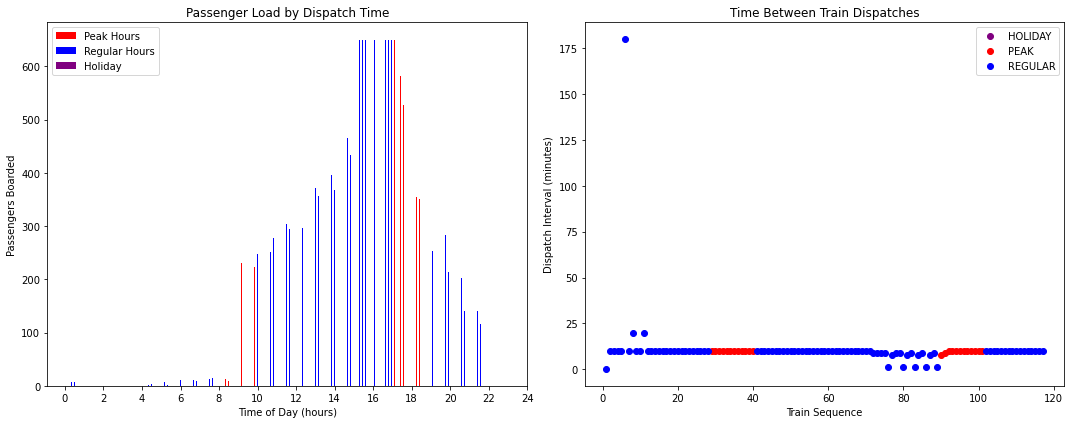


=== Summary Statistics ===
Average passengers per train: 290.2
Maximum passengers on a train: 650
Minimum dispatch interval: 1 minutes
Maximum dispatch interval: 180 minutes

=== Performance by Period Type ===

PEAK:
  Trains dispatched: 24
  Avg passengers: 304.8
  Avg dispatch interval: 9.9 min

REGULAR:
  Trains dispatched: 93
  Avg passengers: 286.4
  Avg dispatch interval: 11.3 min


In [40]:
import pandas as pd
import numpy as np
import simpy
from statsmodels.tsa.statespace.sarimax import SARIMAX
import random
import matplotlib.pyplot as plt
from scipy.stats import poisson

# Zero-Inflated Poisson implementation
def zero_inflated_poisson(lam, pi, size=1):
    """Manual implementation of Zero-Inflated Poisson"""
    zeros = np.random.random(size) < pi
    pois = poisson.rvs(max(lam, 0.1), size=size)
    return np.where(zeros, 0, pois)

# Load and prepare data
file_path = 'TUNEL_corrected_with_outliers_handled.csv'
data = pd.read_csv(file_path)
data['timestamp'] = pd.to_datetime(data['transition_date'] + ' ' + data['transition_hour'])
data = data.sort_values(by='timestamp')
data.set_index('timestamp', inplace=True)

# Feature Engineering
data['hour_of_day'] = data.index.hour
data['lag_1'] = data['number_of_passenger_corrected'].shift(1)
data['lag_24'] = data['number_of_passenger_corrected'].shift(24)
data['rolling_mean_24'] = data['number_of_passenger_corrected'].rolling(window=24).mean()
data['rolling_std_24'] = data['number_of_passenger_corrected'].rolling(window=24).std()
data['temp'] = data['temp'].fillna(data['temp'].mean())
data.dropna(inplace=True)

# SARIMAX Model
ts_data = data['number_of_passenger_corrected']
exog_features = data[['temp', 'holiday', 'week_day', 'hour_of_day', 'lag_1', 'lag_24', 'rolling_mean_24', 'rolling_std_24']]
model = SARIMAX(ts_data, exog=exog_features, order=(5, 0, 2))
result = model.fit(disp=False)

# Random day selection
days_available = data.index.date
random_day = random.choice(days_available)
print(f"Selected Day for Simulation: {random_day}")
test_data = ts_data[str(random_day)]
test_exog = exog_features.loc[str(random_day)]  # Use loc to maintain alignment
test_forecast = result.get_forecast(steps=len(test_data), exog=test_exog).predicted_mean

# Simulation Parameters
TRAIN_CAPACITY = 650
MAX_WAIT_TIME = 10  # minutes

# Time Parameters
MORNING_PEAK = (8, 10)   # 8 AM - 10 AM
EVENING_PEAK = (17, 19)  # 5 PM - 7 PM
PEAK_MULTIPLIER = 1.5    # 50% increase during peaks
HOLIDAY_ZIP_P = 0.3      # Zero-Inflation probability for holidays
MIN_LAMBDA = 0.1         # Minimum arrival rate to prevent errors
REGULAR_DISAGGREGATION = None  # Will be set after finding optimal

def safe_poisson(lam):
    """Safe Poisson generator with minimum lambda"""
    return poisson.rvs(max(lam, MIN_LAMBDA))

def simulate_disaggregation(k_minutes, hourly_forecast, day_exog, verbose=False):
    env = simpy.Environment()
    passenger_queue = []
    train_log = []
    
    def passenger_arrival(env, hourly_forecast, queue, day_exog):
        for hour, forecast in enumerate(hourly_forecast):
            is_weekend = (day_exog.iloc[hour]['week_day'] <= 2)
            is_holiday = (day_exog.iloc[hour]['holiday'] == 1)
            current_hour = int(day_exog.iloc[hour]['hour_of_day'])
            
            # Determine temporal disaggregation period
            if is_holiday or (not is_weekend and (MORNING_PEAK[0] <= current_hour < MORNING_PEAK[1] or 
                            EVENING_PEAK[0] <= current_hour < EVENING_PEAK[1])):
                active_k = k_minutes
            else:
                active_k = REGULAR_DISAGGREGATION if REGULAR_DISAGGREGATION else k_minutes
            
            # Apply distribution
            if is_holiday:
                total_passengers = zero_inflated_poisson(lam=forecast, pi=HOLIDAY_ZIP_P)[0]
                arrival_type = "HOLIDAY"
            elif not is_weekend and (MORNING_PEAK[0] <= current_hour < MORNING_PEAK[1] or 
                                   EVENING_PEAK[0] <= current_hour < EVENING_PEAK[1]):
                total_passengers = safe_poisson(forecast * PEAK_MULTIPLIER)
                arrival_type = "PEAK"
            else:
                total_passengers = safe_poisson(forecast)
                arrival_type = "REGULAR"
            
            total_passengers = max(int(total_passengers), 0)
            
            if verbose:
                print(f"Hour {current_hour:02d}:00 | Type: {arrival_type:<8} | Forecast: {forecast:.0f} | Actual: {total_passengers}")
            
            bins_per_hour = 60 // active_k
            passengers_per_bin = total_passengers / bins_per_hour

            for bin_idx in range(bins_per_hour):
                passengers = int(safe_poisson(passengers_per_bin)) if passengers_per_bin > 0 else 0
                for _ in range(passengers):
                    queue.append(env.now)
                yield env.timeout(active_k)

    def train_service(env, queue, train_capacity, log):
        while True:
            passengers_onboard = 0
            wait_time = 0
            
            while (passengers_onboard < train_capacity) and (wait_time < MAX_WAIT_TIME):
                yield env.timeout(1)
                passengers_waiting = len(queue)
                can_board_now = min(train_capacity - passengers_onboard, passengers_waiting)
                
                passengers_onboard += can_board_now
                del queue[:can_board_now]
                wait_time += 1
                if passengers_onboard == train_capacity:
                    break

            if passengers_onboard > 0:
                log.append((env.now, passengers_onboard))
                if verbose:
                    print(f"Train dispatched at {int(env.now//60):02d}:{int(env.now%60):02d} | Passengers: {passengers_onboard}")

    env.process(passenger_arrival(env, hourly_forecast, passenger_queue, day_exog))
    env.process(train_service(env, passenger_queue, TRAIN_CAPACITY, train_log))
    env.run(until=1440)
    return train_log

# Find optimal temporal disaggregation for regular hours
print("Finding optimal temporal disaggregation for regular hours...")
regular_hours_mask = (test_exog['week_day'] > 2) & (test_exog['holiday'] == 0) & \
                    ~((test_exog['hour_of_day'] >= MORNING_PEAK[0]) & (test_exog['hour_of_day'] < MORNING_PEAK[1])) & \
                    ~((test_exog['hour_of_day'] >= EVENING_PEAK[0]) & (test_exog['hour_of_day'] < EVENING_PEAK[1]))

regular_forecast = test_forecast[regular_hours_mask.values]
regular_exog = test_exog[regular_hours_mask]

regular_results = {}
for k in range(1, 21):
    train_log = simulate_disaggregation(k, regular_forecast, regular_exog)
    if len(train_log) > 1:
        dispatch_intervals = [train_log[i][0] - train_log[i-1][0] for i in range(1, len(train_log))]
        avg_gap = np.mean(dispatch_intervals)
    else:
        avg_gap = float('inf')
    regular_results[k] = avg_gap
    print(f"k={k}: Avg dispatch interval = {avg_gap:.2f} minutes")

REGULAR_DISAGGREGATION = min(regular_results, key=regular_results.get)
print(f"\nOptimal temporal disaggregation for regular hours: {REGULAR_DISAGGREGATION} minutes")

# Run full simulation
print("\n=== Running Full Simulation ===")
train_log = simulate_disaggregation(REGULAR_DISAGGREGATION, test_forecast, test_exog, verbose=True)

# Process results
dispatch_times = [t[0] for t in train_log]
passenger_counts = [t[1] for t in train_log]
dispatch_intervals = [0] + [dispatch_times[i] - dispatch_times[i-1] for i in range(1, len(dispatch_times))]

# Calculate midnight to 9 AM trains
midnight_to_9am_trains = sum(1 for t in dispatch_times if t < 9*60)  # 9 AM = 540 minutes
total_trains = len(train_log)

# Create results dataframe
results_df = pd.DataFrame({
    'Train #': range(1, len(train_log)+1),
    'Dispatch Time': [f"{int(t//60):02d}:{int(t%60):02d}" for t in dispatch_times],
    'Passengers Boarded': passenger_counts,
    'Dispatch Interval (min)': dispatch_intervals
})

# Add time classification
def classify_time(minutes):
    hour = int(minutes // 60)
    idx = test_exog.index[test_exog['hour_of_day'] == hour][0]
    is_weekend = test_exog.loc[idx, 'week_day'] <= 2
    is_holiday = test_exog.loc[idx, 'holiday'] == 1
    
    if is_holiday:
        return "HOLIDAY"
    elif not is_weekend and ((MORNING_PEAK[0] <= hour < MORNING_PEAK[1]) or 
                           (EVENING_PEAK[0] <= hour < EVENING_PEAK[1])):
        return "PEAK"
    return "REGULAR"

results_df['Period Type'] = [classify_time(t) for t in dispatch_times]

print("\n=== Simulation Results ===")
print(f"Total trains dispatched (midnight to 9 AM): {midnight_to_9am_trains}")
print(f"Total trains dispatched (whole day): {total_trains}")
print(f"Final total trains dispatched: {total_trains - midnight_to_9am_trains}")
print(f"Regular hours temporal disaggregation: {REGULAR_DISAGGREGATION} minutes")
print(results_df.to_string(index=False))

# Visualization
plt.figure(figsize=(15, 6))

# Passenger counts by time
plt.subplot(1, 2, 1)
times = [t/60 for t in dispatch_times]
color_map = {'HOLIDAY': 'purple', 'PEAK': 'red', 'REGULAR': 'blue'}
colors = [color_map[pt] for pt in results_df['Period Type']]
plt.bar(times, passenger_counts, width=0.02, color=colors)
plt.xlabel('Time of Day (hours)')
plt.ylabel('Passengers Boarded')
plt.title('Passenger Load by Dispatch Time')
plt.xticks(range(0, 25, 2))

# Create legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='red', label='Peak Hours'),
                   Patch(facecolor='blue', label='Regular Hours'),
                   Patch(facecolor='purple', label='Holiday')]
plt.legend(handles=legend_elements)

# Dispatch intervals by period type
plt.subplot(1, 2, 2)
for period_type in ['HOLIDAY', 'PEAK', 'REGULAR']:
    mask = results_df['Period Type'] == period_type
    plt.plot(np.where(mask)[0]+1, results_df[mask]['Dispatch Interval (min)'], 
            'o', label=period_type, color=color_map[period_type])
plt.xlabel('Train Sequence')
plt.ylabel('Dispatch Interval (minutes)')
plt.title('Time Between Train Dispatches')
plt.legend()

plt.tight_layout()
plt.show()

# Additional summary stats
print("\n=== Summary Statistics ===")
print(f"Average passengers per train: {np.mean(passenger_counts):.1f}")
print(f"Maximum passengers on a train: {max(passenger_counts)}")
print(f"Minimum dispatch interval: {min(dispatch_intervals[1:]) if len(dispatch_intervals) > 1 else 0} minutes")
print(f"Maximum dispatch interval: {max(dispatch_intervals[1:]) if len(dispatch_intervals) > 1 else 0} minutes")

# Breakdown by period type
print("\n=== Performance by Period Type ===")
for period_type in ['HOLIDAY', 'PEAK', 'REGULAR']:
    mask = results_df['Period Type'] == period_type
    if sum(mask) > 0:
        print(f"\n{period_type}:")
        print(f"  Trains dispatched: {sum(mask)}")
        print(f"  Avg passengers: {results_df[mask]['Passengers Boarded'].mean():.1f}")
        print(f"  Avg dispatch interval: {results_df[mask]['Dispatch Interval (min)'].mean():.1f} min")